In [ ]:
#title: a very, very rudimentary DL model (littlerodentmodel.h5) for classifying rodent molars by diet 
#author: Madeline Ball 

#personal notes (as of 10/31/2024):
#right now, the training dataset is only a handful of cranial photos in the ventral view that I tried to grab quickly, and its analysis is not limited only to molars 
#for the sake of standardization, photos are only from MVZ specimens (obtained from Arctos) that have had professional photos taken on a black background
#dietary categories follow those outlined in Keller et al. (in review), insectivory has been removed from the training data due to a lack of specimens
#i would estimate that, in order to obtain a functional model with any real predictive power, one would need to obtain a minimum of 2,000 images of specimens for each group/category
#these 2,000 images may not necessarily need to be 2,000 unique specimens, but could instead be 500 unique specimen photos that have been augmented in 3 additional ways (see chunk 2 for a demo of this process)
#a handful of species with known diet and available images will need to be withheld from the training data to be used as validation data

#additional online repositories that may have suitable data (images that have a reasonable degree of standardization) based just on my own brief viewing of what is available include:
#> UTEP:Mamm (Arctos)
#> UAM:Mamm (Arctos)
#> USNM - collections.nmnh.si.edu
#> FMNH - collections-zoology.fieldmuseum.org

#it is really a matter of someone going through and saving all of the images for modern species with known diet then categorizing them so that they can be added to the dataset
#the dataset used here is far too small to ascertain anything, and at the moment it seems that my dataset is so small that the model is simply memorizing the images I feed to it, not recognizing patterns and then applying that knowledge
#i have tried to avoid this by making my validation dataset a permanent entity (not shuffling every epoch), but alas, it is just too ignorant to do anything different  

In [1]:
#this code chunk resizes images to a standard size that is accepted by the base model I have chosen (for now)
#i am still trying to determine whether or not the distortion imposed by this process will impact the model's ability to learn and recognize patterns
#or if the negative effects of image distortion are counteracted by the fact that the distortion is universally applied

#loading packages
import os 
from PIL import Image

#defines input and output parent folders
input_folder = "C:\\Users\\maddi\\coding_proj\\rodent_imgs\\train"
output_folder = "C:\\Users\\maddi\\coding_proj\\rodent_imgs\\trainresized"
target_size = (224, 224)  #setting desired image size, may need to be adjusted to account for image distortion

#loops through each subfolder in the input folder
for subfolder in os.listdir(input_folder):
    subfolder_path = os.path.join(input_folder, subfolder)
    
    #makes sure we are only processing directories
    if os.path.isdir(subfolder_path):
        #creating output subfolders
        output_subfolder = os.path.join(output_folder, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)
        
        #loops through each image in each subfolders
        for filename in os.listdir(subfolder_path):
            if filename.endswith((".jpg", ".jpeg", ".png")):  #selects only image files
                img_path = os.path.join(subfolder_path, filename)
                with Image.open(img_path) as img:
                    #resizes the image
                    resized_img = img.resize(target_size)
                    #saves the resized image to the correct new output subfolder
                    resized_img.save(os.path.join(output_subfolder, filename))


Resized and saved MVZ_100628_Sigmodon_hispidus.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_10438_Neotoma_lepida.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_11152_Neotoma_cinerea.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_118_Microtus_pennsylvanicus.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_25485_Xerospermophilus_tereticaudus.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_27539_Marmota_fortirostris.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_388_Myodes_rutilus.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_51221_Myodes_rutilus.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized and saved MVZ_557_Myodes_rutilus.jpg in C:\Users\maddi\coding_proj\rodent_imgs\trainresized\foli
Resized 

Found 54 images belonging to 5 classes.
Found 4 images belonging to 5 classes.


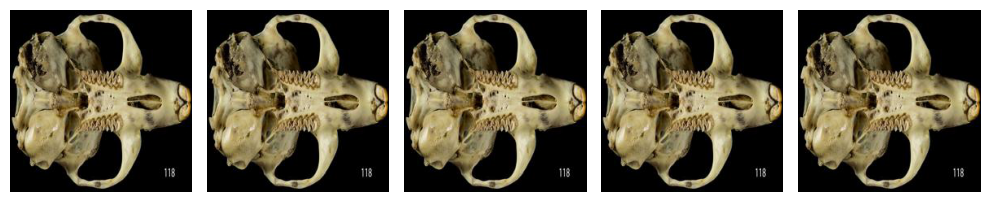

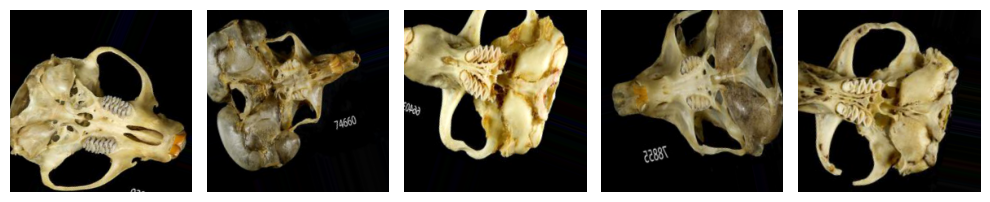

In [20]:
#this code chunk defines the input folder, image generator for augmenting the training data to "increase" the amount of things there are for the 
#model to look at, and then creates the augmented training data and validation data objects

#loading packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#select input folder path
input_folder = "C:\\Users\\maddi\\coding_proj\\rodent_imgs\\trainresized"

#define image generator for training with augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalizing pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2  
)

#create training data with augmentations
train_generator = train_datagen.flow_from_directory(
    input_folder,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    subset='training', 
    shuffle=True  #shuffle training data
)

#define image generator for validation without augmentations
val_datagen = ImageDataGenerator(
    rescale=1.0/255  
)

#create validation data without augmentations
val_generator = val_datagen.flow_from_directory(
    'C:\\Users\\maddi\\coding_proj\\rodent_imgs\\val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=False 
)

#this can be used to visualize augmentations, i did this just so i can know what i am actually doing when defining the image generator
def visualize_augmentations(generator, num_images=5): #creates figure to display images
    plt.figure(figsize=(10, 10))
    
    for i in range(num_images): 
        img, _ = next(generator) #grabs a batch of images and labels from the generator
        
        #shows the first image in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img[0])  # Show the first image
        plt.axis('off')     # Hide axis
    plt.tight_layout()
    plt.show()

#calls the function with training generator images to visualize augmentations and validation generator images for comparison
visualize_augmentations(val_generator)
visualize_augmentations(train_generator)


In [26]:
#load in and configure model with pre-trained layers (layers frozen from training data so the model starts with some basic knowledge about shapes and shading before initializing training)
#model options include ResNet50, EfficientNet0, MobileNetV2
#i tried all 3 but went with MobileNetV2 for now, I think that there is probably better options though

#loading packages 
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')  #num_classes can be adjusted to account for the number of categories being used
])


In [27]:
#compiling model (telling it how it should learn things and what it should tell me about its progress on how it is learning things) 
#there are many different options for this, and if the project moves forward, what we use here will likely evolve as we improve our dataset

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
#train the model using the training and validation data we made

history = model.fit(
    train_generator,
    validation_data = val_generator,
    shuffle = True,
    epochs = 20  #the amount of times it is presented the data will need to increase with the amount of data we have
) #i think i need to edit this such that the augmentation process is being looped over every epoch (i.e. the photos are being re-augmented every epoch 
#so it is going to always be being given new, unique data every time we tell it to look over things 

Epoch 1/50
14/14 [==============================] - 1s 64ms/step - loss: 0.3368 - accuracy: 0.9074 - val_loss: 0.8873 - val_accuracy: 0.7500
Epoch 2/50
14/14 [==============================] - 1s 63ms/step - loss: 0.3749 - accuracy: 0.8519 - val_loss: 0.8024 - val_accuracy: 0.7500
Epoch 3/50
14/14 [==============================] - 1s 61ms/step - loss: 0.3002 - accuracy: 0.8704 - val_loss: 0.9327 - val_accuracy: 0.7500
Epoch 4/50
14/14 [==============================] - 1s 62ms/step - loss: 0.3465 - accuracy: 0.8704 - val_loss: 0.9740 - val_accuracy: 0.7500
Epoch 5/50
14/14 [==============================] - 1s 63ms/step - loss: 0.2885 - accuracy: 0.8889 - val_loss: 0.8326 - val_accuracy: 0.7500
Epoch 6/50
14/14 [==============================] - 1s 61ms/step - loss: 0.2940 - accuracy: 0.9074 - val_loss: 0.9385 - val_accuracy: 0.7500
Epoch 7/50
14/14 [==============================] - 1s 64ms/step - loss: 0.4050 - accuracy: 0.8704 - val_loss: 1.1091 - val_accuracy: 0.7500
Epoch 8/50
14

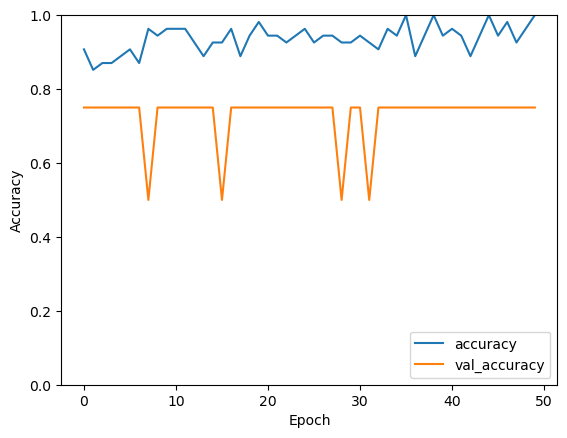

In [32]:
#plot the training history to see how it did at classifying the validation data

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#as you can see, it sucks at doing what it is supposed to be doing.

Shape of validation images: (4, 224, 224, 3)
Labels: [[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


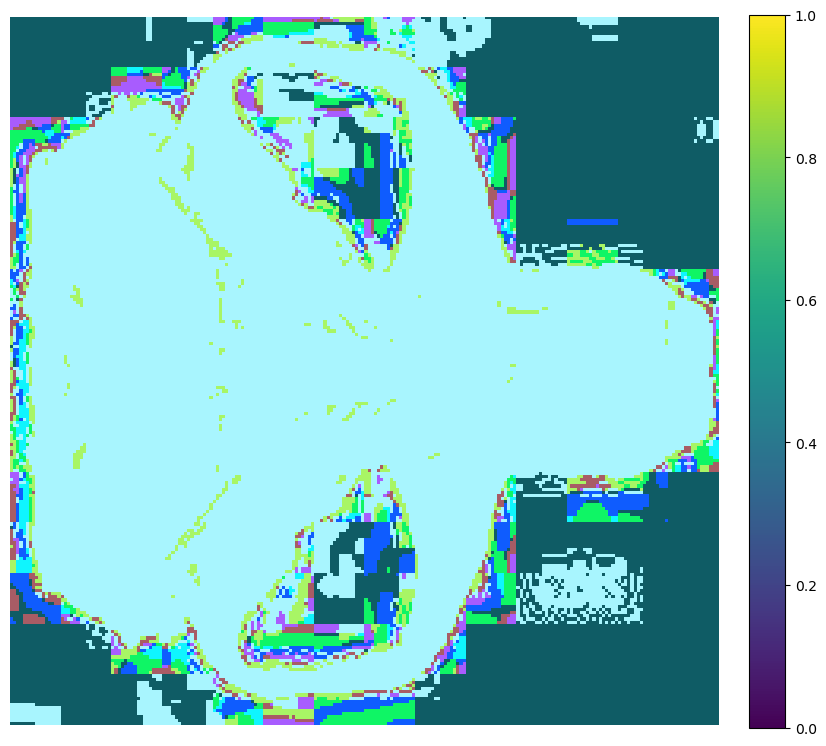

In [68]:
#ignore this complete disaster of a chunk for now. i am trying to get it to generate a heatmap on one of the images in the validation data that highlights 
#what parts of the image it is interested in/it used to classify it that way i can get a better idea of how exactly it is categorizing things based on morphology 
#or if it is using other parts of the images that aren't immediately apparent to me to be able to accurately categorize things. this will become more
#important after i have more data. if it is using part of the morphology that wouldn't be obvious to me as something particularly important in classification,
#that is good and is exactly what i want. but, if it is using random things (like the specimen numbers embedded into the images for MVZ specimens), that is not so good. 

#loading packages
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

last_dense_layer_name = "dense_1" 

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_dense_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_dense_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        dense_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, dense_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=0)

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, dense_outputs), axis=-1)

    heatmap = tf.maximum(heatmap, 0)

    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

def overlay_heatmap(heatmap, original_image, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_VIRIDIS)
    
    original_image = np.uint8(original_image)

    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_color, alpha, 0)

    return overlayed_image

images, labels = next(val_generator)

print("Shape of validation images:", images.shape)  # Should show the shape of your images
print("Labels:", labels)  # To see if labels correspond to validation data

#random_index = np.random.randint(0, images.shape[0])
#img_array = images[random_index:random_index + 1]  # Select a single image and keep the batch dimension
#original_image = images[random_index]  # This is the original image for overlay

heatmap = make_gradcam_heatmap(img_array, model, last_dense_layer_name)

original_image = original_image * 255.0  
original_image = np.clip(original_image, 0, 255) 
original_image = original_image.astype(np.uint8) 

overlayed_image = overlay_heatmap(heatmap, original_image)

plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')  # Hide axes
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
plt.show()


In [70]:
#save the model for future use and additional training

model.save('C:\\Users\\maddi\\coding_proj\\littlerodentmodel.h5')